In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import collections
import gymnasium as gym
import random
# import rl_utils

In [22]:
## Predefined functions from rl_utils
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

## Carpole Environment
state space: (x, v, ang, tip_v)
action space: (left, right)
minmax bound for state: x in [-2.4 2.4], v in [-Inf, Inf], ang in [-40deg, 40deg], tip_v in [-Inf, Inf]

In [23]:
## Q-net with only one hidden layer
class Q_net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Q_net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [24]:
class DQN:
    '''DQN algorithm implementation'''
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, epsilon, tgt_update, device):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        # trained Q-network and target Q-network
        self.Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        self.target_Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        # optimizer and hyperparameters
        self.optimizer = torch.optim.Adam(self.Q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.tgt_update = tgt_update # target network update frequency
        self.count = 0 # to count the number of updates
        self.device = device # to specify the device (CPU or GPU)

    # epsilon-greedy action selection
    def action_selection(self, state):
        # table version
        # if np.random.rand() < self.epsilon:
        #     action = np.random.choice(self.n_action)
        # else:
        #     action = np.argmax(self.Q_table[state])
        # return action

        # functional version
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float).to(self.device)
            q_values = self.Q_net(state_tensor)
            action = torch.argmax(q_values).item()
        
        return action
    
    def DQN_main(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        q_vals = self.Q_net(states).gather(1, actions)
        # max Q-value of next states
        with torch.no_grad():
            max_next_q_vals = self.target_Q_net(next_states).max(1)[0].view(-1, 1)
        # calculate target Q-values (TD error target)
        q_target = rewards + self.gamma * max_next_q_vals * (1 - dones)
        dqn_loss = F.mse_loss(q_vals, q_target, reduction='mean')
        # optimizer
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # update target Q-network
        if self.count % self.tgt_update == 0:
            self.target_Q_net.load_state_dict(self.Q_net.state_dict())
        self.count += 1

In [25]:
class DDQN:
    '''DDQN algorithm implementation'''
    def __init__(self, state_dim, hidden_dim, action_dim, lr, gamma, epsilon, tgt_update, device):
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        # trained Q-network and target Q-network
        self.Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        self.target_Q_net = Q_net(state_dim, hidden_dim, action_dim).to(device)
        # optimizer and hyperparameters
        self.optimizer = torch.optim.Adam(self.Q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.tgt_update = tgt_update # target network update frequency
        self.count = 0 # to count the number of updates
        self.device = device # to specify the device (CPU or GPU)

    # epsilon-greedy action selection
    def action_selection(self, state):
        # table version
        # if np.random.rand() < self.epsilon:
        #     action = np.random.choice(self.n_action)
        # else:
        #     action = np.argmax(self.Q_table[state])
        # return action

        # functional version
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float).to(self.device)
            q_values = self.Q_net(state_tensor)
            action = torch.argmax(q_values).item()
        return action
    
    def DDQN_main(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        q_vals = self.Q_net(states).gather(1, actions)
        # max Q-value of next states
        # two steps in DDQN: 1. argmax_{a'}Q_net(s', a'); 2. Q_target(s, argmax_{a'}Q_net(s', a')), 
        # two networks are used to decouple the action selection and Q-value estimation
        # in DQN, we only use Q_target(s', a') to calculate the target Q-value
        with torch.no_grad():
            max_action = torch.argmax(self.Q_net(next_states), dim=1, keepdim=True)
            max_next_q_vals = self.target_Q_net(next_states).gather(1, max_action)
        # calculate target Q-values (TD error target)
        q_target = rewards + self.gamma * max_next_q_vals * (1 - dones)
        dqn_loss = F.mse_loss(q_vals, q_target, reduction='mean')
        # optimizer
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # update target Q-network
        if self.count % self.tgt_update == 0:
            self.target_Q_net.load_state_dict(self.Q_net.state_dict())
        self.count += 1

In [26]:
## Main program
lr = 1e-3
hidden_dim = 80
gamma = 0.98
epsilon = 0.05
num_episodes = 300
tgt_update = 10
buffer_size = 10000 # replay buffer size
minimal_size = 500 # minimal size of replay buffer to start training
batch_size = 100 # batch size for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1')

env.action_space.seed(0)  # set seed for reproducibility
random.seed(7)
np.random.seed(2)
torch.manual_seed(1)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim=action_dim, lr=lr, gamma=gamma, epsilon=epsilon, tgt_update=tgt_update, device=device)

return_list = []
for i in range(10):
    for i_ep in range(int(num_episodes/10)):
        episode_return = 0
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.action_selection(state)
            next_state, reward, done, _, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            
            if replay_buffer.size() >= minimal_size:
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {'states': b_s, 
                                   'actions': b_a,
                                   'rewards': b_r, 
                                   'next_states': b_ns, 
                                   'dones': b_d}
                agent.DQN_main(transition_dict)
        # record return
        return_list.append(episode_return)
        if (i_ep + 1) % 10 == 0:
            print(f'Episode {i * int(num_episodes/10) + i_ep + 1}, Return: {episode_return}')
               


TypeError: 'int' object is not callable

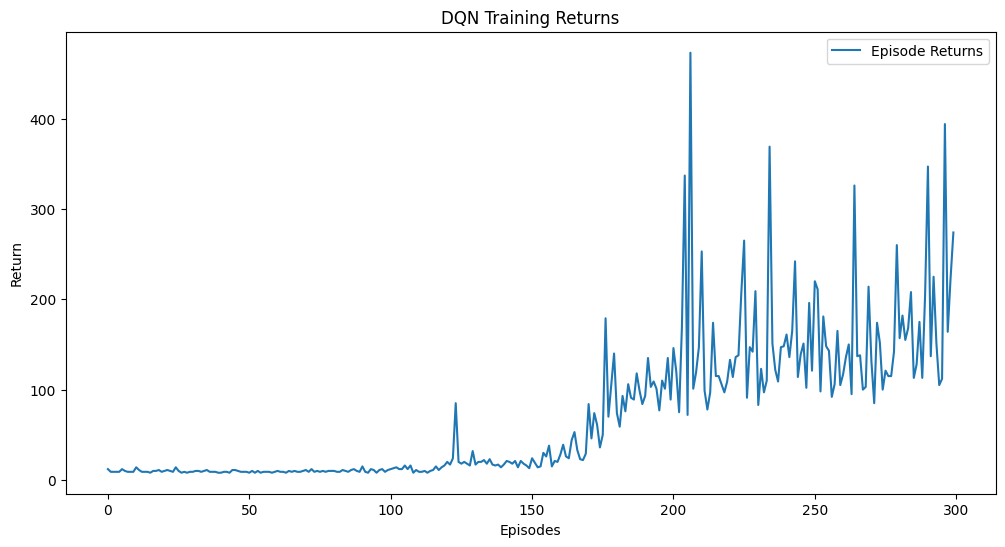

In [ ]:
## Plotting the results
episodes_list = list(range(len(return_list)))
plt.figure(figsize=(12, 6))
plt.plot(episodes_list, return_list, label='Episode Returns')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('DQN Training Returns')
plt.legend()

# move average return list to be added